<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width = 400, align ="center"></a>

<h1 align=center><font size = 5> SVM (Support Vector Machines)</font></h1>

In this notebook, you will use SVM (Support Vector Machines) to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data are transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

In [51]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

###  Load the Cancer data 
The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

For the purposes of this example, we're using a dataset that has a relatively small number of predictors in each record. To download the data, we will use `!wget` to download it from IBM Object Storage.  
__Did you know?__ When it comes to Machine Learning, you will likely be working with large datasets. As a business, where can you host your data? IBM is offering a unique opportunity for businesses, with 10 Tb of IBM Cloud Object Storage: [Sign up now for free](http://cocl.us/ML0101EN-IBM-Offer-CC)

### Load Data From CSV File  

In [52]:
df = pd.read_csv("stroke.csv")
avg_norm_loss = df['bmi'].astype("float").mean(axis=0) 
df['bmi'].replace(np.nan, avg_norm_loss, inplace=True) 
print(df.columns)

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

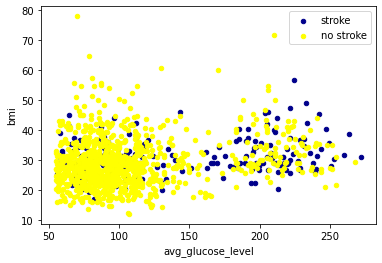

In [53]:
ax = df[df['stroke'] == 1][0:1000].plot(kind='scatter', x='avg_glucose_level', y='bmi', color='DarkBlue', label='stroke');
df[df['stroke'] == 0][0:1000].plot(kind='scatter', x='avg_glucose_level', y='bmi', color='Yellow', label='no stroke', ax=ax);
plt.show()

## Data pre-processing and selection

Lets first look at columns data types:

In [54]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

It looks like the __BareNuc__ column includes some values that are not numerical. We can drop those rows:

In [55]:
X = np.asarray(df[['gender', 'age', 'hypertension', 'ever_married', 'work_type', 'Residence_type','heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status']])

In [56]:
sex = preprocessing.LabelEncoder()
sex.fit(['Male', 'Female', 'Other'])
X[:, 0] = sex.transform(X[:, 0])
married = preprocessing.LabelEncoder()
married.fit(['Yes', 'No'])
X[:, 3] = married.transform(X[:, 3])
work = preprocessing.LabelEncoder()
work.fit(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'])
X[:, 4] = work.transform(X[:, 4])
residence = preprocessing.LabelEncoder()
residence.fit(['Urban', 'Rural'])
X[:, 5] = residence.transform(X[:, 5])
smoke = preprocessing.LabelEncoder()
smoke.fit(['formerly smoked', 'never smoked', 'smokes', 'Unknown'])
X[:, 9] = smoke.transform(X[:, 9])

print(X[0:5])

[[1 67.0 0 1 2 1 1 228.69 36.6 1]
 [0 61.0 0 1 3 0 0 202.21 28.893236911794673 2]
 [1 80.0 0 1 2 0 1 105.92 32.5 2]
 [0 49.0 0 1 2 1 0 171.23 34.4 3]
 [0 79.0 1 1 3 0 0 174.12 24.0 2]]


We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [57]:
y = np.asarray(df['stroke'])
y [0:5]

array([1, 1, 1, 1, 1], dtype=int64)

## Train/Test dataset

Okay, we split our dataset into train and test set:

In [58]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (4088, 10) (4088,)
Test set: (1022, 10) (1022,)


# Modeling (SVM with Scikit-learn)

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

    1.Linear
    2.Polynomial
    3.Radial basis function (RBF)
    4.Sigmoid
Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.

In [59]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

After being fitted, the model can then be used to predict new values:

In [60]:
yhat = clf.predict(X_test)
yhat [0:5]

array([0, 0, 0, 0, 0], dtype=int64)

## Evaluation

In [61]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[972   0]
 [ 50   0]]
Confusion matrix, without normalization
[[972   0]
 [ 50   0]]


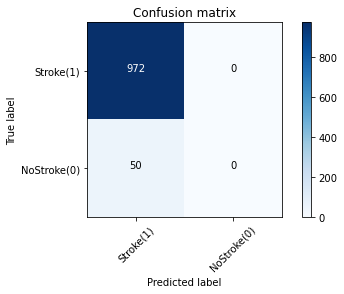

In [63]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0, 1])
np.set_printoptions(precision=1)
print(cnf_matrix)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Stroke(1)', 'NoStroke(0)'], normalize=False,title='Confusion matrix')
plt.show()

You can also easily use the __f1_score__ fron sklearn library:

In [64]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.9272278675557003

Lets try jaccard index for accuracy:

In [67]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat)

0.0

## Practice
Can you rebuild the model, but this time with a __linear__ kernel? You can use __ kernel='linear'__ option, when you define the svm. How the accuracy changes with the new kernel function?

In [68]:
# write your code here




Double-click __here__ for the solution.

<!-- Your answer is below:
    
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat2))

-->

## Want to learn more?

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: [SPSS Modeler](http://cocl.us/ML0101EN-SPSSModeler).

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at [Watson Studio](https://cocl.us/ML0101EN_DSX)

### Thanks for completing this lesson!

Notebook created by: <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>

<hr>
Copyright &copy; 2018 [Cognitive Class](https://cocl.us/DX0108EN_CC). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).​